In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
cv2.__version__

'4.1.0'

In [4]:
cap=cv2.VideoCapture("../Gauge/video.mp4")

"""if cap.isOpened():
    ret, frame = cap.read()
else:
    ret=False"""
    
while True:
    ret, frame = cap.read()
    grey = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    (thresh, dst2) = cv2.threshold(grey, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    edges=cv2.Canny(dst2,50,250,apertureSize=5,L2gradient=True)
    minLineLength = 10
    maxLineGap = 0
    lines = cv2.HoughLinesP(image=edges, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)
    #print(lines[0])
    for _,rho, theta,th in lines[0]:
        a=np.cos(theta)
        b=np.sin(theta)
        x0=a*rho
        y0=b*rho
        pts1=(int(x0 + 1000*(-b)),int(y0 + 1000*(a)))
        pts2=(int(x0 - 1000*(-b)),int(y0 - 1000*(a)))
        cv2.line(frame,pts1,pts2,(0,255,0),3)
    
    cv2.imshow("",frame)
    
    if cv2.waitKey(1) == 27:
        break
cv2.destroyAllWindows()
cap.release()

# Fitting this to our use case

In [3]:
def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [4]:
def avg_circles(circles, b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

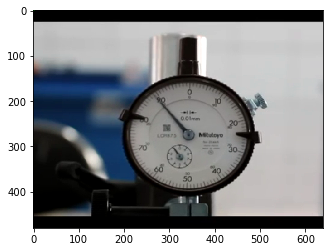

In [9]:
cap=cv2.VideoCapture("../Gauge/video.mp4")

"""if cap.isOpened():
    ret, frame = cap.read()
else:
    ret=False"""
    
while True:
    ret, frame = cap.read()
    grey = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    #edges=cv2.Canny(grey,50,150,apertureSize=5,L2gradient=True)
    #(thresh, dst2) = cv2.threshold(grey, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    #plt.imshow(dst2)
    #dst2 = cv2.medianBlur(dst2, 5)
    #dst2 = cv2.GaussianBlur(dst2, (5, 5), 0)
    #dst2 = cv2.Canny(dst2, 50, 150)
    minLineLength = 10
    maxLineGap = 0
    circles = cv2.HoughCircles(grey, cv2.HOUGH_GRADIENT, 1, 80)
    
    #*****************************************************************************************************
    a, b, c = circles.shape
    x,y,r = avg_circles(circles, b)

    #draw center and circle
    cv2.circle(frame, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
    cv2.circle(frame, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle

    #for testing, output circles on image
    #cv2.imwrite('gauge-%s-circles.%s' % (gauge_number, file_type), img)


    #for calibration, plot lines from center going out at every 10 degrees and add marker
    #for i from 0 to 36 (every 10 deg)

    '''
    goes through the motion of a circle and sets x and y values based on the set separation spacing.  Also adds text to each
    line.  These lines and text labels serve as the reference point for the user to enter
    NOTE: by default this approach sets 0/360 to be the +x axis (if the image has a cartesian grid in the middle), the addition
    (i+9) in the text offset rotates the labels by 90 degrees so 0/360 is at the bottom (-y in cartesian).  So this assumes the
    gauge is aligned in the image, but it can be adjusted by changing the value of 9 to something else.
    '''
    separation = 10.0 #in degrees
    interval = int(360 / separation)
    p1 = np.zeros((interval,2))  #set empty arrays
    p2 = np.zeros((interval,2))
    p_text = np.zeros((interval,2))
    for i in range(0,interval):
        for j in range(0,2):
            if (j%2==0):
                p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
            else:
                p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
    text_offset_x = 10
    text_offset_y = 5
    for i in range(0, interval):
        for j in range(0, 2):
            if (j % 2 == 0):
                p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
                p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+27) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
            else:
                p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
                p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+27) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

    #add the lines and labels to the image
    for i in range(0,interval):
        cv2.line(frame, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
        cv2.putText(frame, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)    
    
    
    #*****************************************************************************************************
    min_angle = 0 #raw_input('Min angle (lowest possible angle of dial) - in degrees: ') #the lowest possible angle
    max_angle = 359 #raw_input('Max angle (highest possible angle) - in degrees: ') #highest possible angle
    min_value = 0 #raw_input('Min value: ') #usually zero
    max_value = 99 #raw_input('Max value: ') #maximum reading of the gauge
    units = 'mm' #raw_input('Enter units: ')
    thresh = 175
    maxValue = 255
    plt.imshow(frame)
    (thresh, dst2) = cv2.threshold(grey, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    dst2 = cv2.medianBlur(dst2, 5)
    dst2 = cv2.Canny(dst2, 50, 150)
    dst2 = cv2.GaussianBlur(dst2, (5, 5), 0)  
    minLineLength = 10
    maxLineGap = 0
    lines = cv2.HoughLinesP(image=grey, rho=3, theta=np.pi / 180, threshold=100,minLineLength=minLineLength, maxLineGap=0)
    #print(lines[0])
    ##########################################################
    final_line_list = []
    #print "radius: %s" %r

    diff1LowerBound = 0.15 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
    diff1UpperBound = 0.25
    diff2LowerBound = 0.5 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
    diff2UpperBound = 1.0

    #print("length of lines %d"%len(lines))

    for i in range(0, len(lines)):
        for x1, y1, x2, y2 in lines[i]:
            diff1 = dist_2_pts(x, y, x1, y1)  # x, y is center of circle
            diff2 = dist_2_pts(x, y, x2, y2)  # x, y is center of circle
            #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
            if (diff1 > diff2):
                temp = diff1
                diff1 = diff2
                diff2 = temp
            # check if line is within an acceptable range
            #if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
                line_length = dist_2_pts(x1, y1, x2, y2)
                # add to final list
                final_line_list.append([x1, y1, x2, y2])
    
    x1 = final_line_list[0][0]
    y1 = final_line_list[0][1]
    x2 = final_line_list[0][2]
    y2 = final_line_list[0][3]
    cv2.line(frame, (x, y), (x2, y2), (0, 255, 0), 2)
    ##########################################################
    
    cv2.imshow("",frame)
    
    if cv2.waitKey(1) == 27:
        break
cv2.destroyAllWindows()
cap.release()

In [ ]:
3